<a href="https://colab.research.google.com/github/MohamedAbuAmira/ML-DL-Examples/blob/master/Transfer_learning_with_TensorFlow_Hub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I write this nootebook with understand every line code and made some modifications on codes from TF docs..
source: https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub

TensorFlow Hub is a way to share pretrained model components

In [1]:
import matplotlib.pylab as plt

import tensorflow as tf

In [2]:
!pip install -q tensorflow-hub
!pip install -q tensorflow-datasets
import tensorflow_hub as hub

from tensorflow.keras import layers

# An ImageNet classifier

## Download the classifier

Use hub.module to load a mobilenet, and tf.keras.layers.Lambda to wrap it up as a keras layer.

In [3]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" 

In [4]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

## Run it on a single image

65536/61306 [================================] - 0s 0us/step


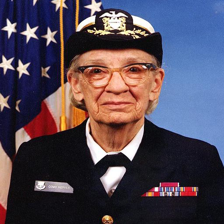

In [5]:
# Download a single image to try the model on.

import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [6]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [7]:
# Add a batch dimension, and pass the image to the model.

result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

**The result is a 1001 element vector of logits, rating the probability of each class for the image.**

In [8]:
# So the top class ID can be found with argmax:

predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

## Decode the predictions

In [10]:
# We have the predicted class ID, Fetch the ImageNet labels, and decode the predictions

labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())
imagenet_labels

array(['background', 'tench', 'goldfish', ..., 'bolete', 'ear',
       'toilet tissue'], dtype='<U30')

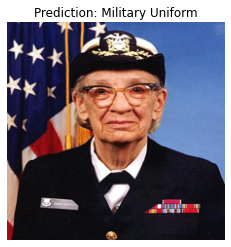

In [11]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

# Simple transfer learning

Using TF Hub it is simple to retrain the top layer of the model to recognize the classes in our dataset

## Dataset

In [18]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

In [19]:
data_root

'/root/.keras/datasets/flower_photos'

The simplest way to load this data into our model is using **tf.keras.preprocessing.image.ImageDataGenerator**,

**All of TensorFlow Hub's image modules expect float inputs in the [0, 1] range. Use the ImageDataGenerator's rescale parameter to achieve this.**

In [20]:
image_generator=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data= image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


In [23]:
3670 // 32

114

In [22]:
len(image_data)

115

In [48]:
image_data.samples, image_data.batch_size

(3670, 32)

In [39]:
#get the class names, we will not use them right now

image_data.class_indices.items()

dict_items([('daisy', 0), ('dandelion', 1), ('roses', 2), ('sunflowers', 3), ('tulips', 4)])

In [21]:
# The resulting object is an iterator that returns image_batch, label_batch pairs.

for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


## Run the classifier on a batch of images

In [24]:
# Now run the classifier on the image batch.

result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [26]:
np.argmax(result_batch, axis=-1)

array([986, 739, 724, 816, 986, 592, 884, 750,  95, 986, 986, 309, 986,
       788, 717, 884, 739, 507, 986, 986, 985, 302, 592,  80, 986, 986,
       329, 717, 990, 986, 986, 986])

In [25]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['daisy', 'pot', 'pinwheel', 'spider web', 'daisy', 'handkerchief',
       'vase', 'quill', 'hummingbird', 'daisy', 'daisy', 'fly', 'daisy',
       'shield', 'picket fence', 'vase', 'pot', 'coil', 'daisy', 'daisy',
       'rapeseed', 'ladybug', 'handkerchief', 'centipede', 'daisy',
       'daisy', 'sea urchin', 'picket fence', 'hip', 'daisy', 'daisy',
       'daisy'], dtype='<U30')

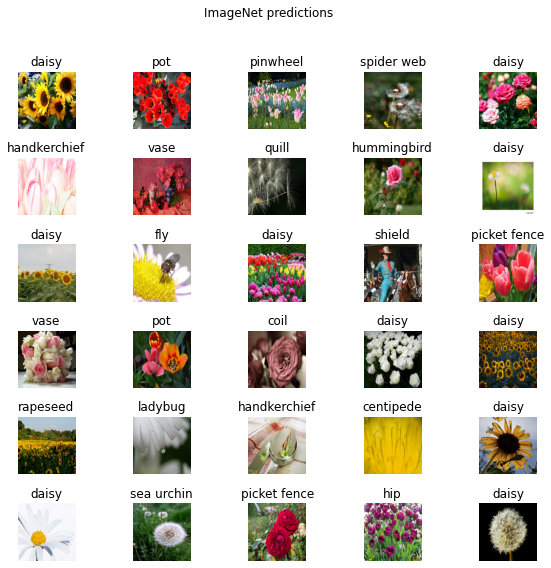

In [27]:
# Now check how these predictions line up with the images:

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

## Download the headless model

TensorFlow Hub also distributes models without the top classification layer. These can be used to easily do transfer learning.

In [40]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" 

In [41]:
# Create the feature extractor.

feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

In [42]:
# It returns a 1280-length vector for each image:

feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [43]:
# Freeze the variables in the feature extractor layer, so that the training only modifies the new classifier layer.

feature_extractor_layer.trainable = False

## Attach a classification head

In [44]:
# Now wrap the hub layer in a tf.keras.Sequential model, and add a new classification layer.

model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(image_data.num_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [45]:
predictions = model(image_batch)

In [46]:
predictions.shape

TensorShape([32, 5])

## Train the model

In [47]:
# Use compile to configure the training process:

model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

To keep this example short train just 2 epochs. To visualize the training progress, use a custom callback to log the loss and accuracy of each batch individually, instead of the epoch average.

In [49]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [50]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit(image_data, epochs=2,
                    steps_per_epoch=steps_per_epoch,
                    callbacks=[batch_stats_callback])

Epoch 1/2
115/115 [==============================] - 125s 1s/step - loss: 0.4833 - acc: 0.8438
Epoch 2/2
115/115 [==============================] - 124s 1s/step - loss: 0.4552 - acc: 0.8125


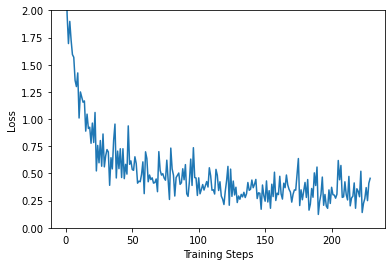

In [51]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

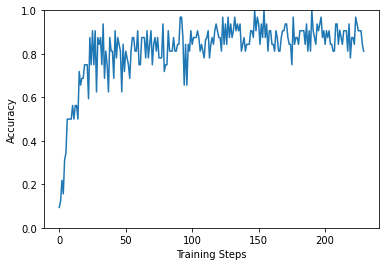

In [52]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

## Check the predictions

In [53]:
# To redo the plot from before, first get the ordered list of class names:

class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

In [61]:
# Run the image batch through the model and convert the indices to class names.

predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

In [65]:
predicted_batch

array([[ -1.3829155 ,  -2.0595489 ,  -3.274996  ,   1.3285763 ,
         -1.093885  ],
       [ -4.1897364 ,  -4.4847355 ,   0.9119788 ,  -3.5036337 ,
          1.9881907 ],
       [ -0.77465737,  -4.6824846 ,  -4.2761064 ,  -4.6780868 ,
          2.3621476 ],
       [ -1.3517272 ,   2.7599902 ,  -3.147638  ,  -4.241546  ,
         -3.8873549 ],
       [ -2.4270716 ,  -2.7139642 ,   1.353488  ,  -4.8290224 ,
          1.4539129 ],
       [ -1.8350122 ,  -4.6895604 ,   0.15660404,  -3.4226928 ,
          1.8744162 ],
       [ -5.379328  ,  -5.54318   ,   4.2222004 ,  -3.0069861 ,
         -0.11700852],
       [ -3.0711565 ,   4.659624  ,  -4.6551857 ,  -5.9978385 ,
         -3.3763514 ],
       [ -2.1284797 ,  -4.95248   ,   0.273039  ,  -3.4932632 ,
          0.75856537],
       [ -1.2134824 ,   0.8401129 ,  -6.043618  ,  -3.8792937 ,
         -3.7373114 ],
       [ -3.4428577 ,  -0.7412518 ,  -3.4799898 ,   3.228279  ,
         -2.9462855 ],
       [  0.7663128 ,  -1.0528855 ,  -3.624

In [62]:
predicted_id

array([3, 4, 4, 1, 4, 4, 2, 1, 4, 1, 3, 0, 4, 2, 4, 2, 4, 2, 4, 3, 3, 1,
       4, 1, 3, 0, 1, 2, 4, 1, 3, 1])

In [63]:
predicted_label_batch

array(['Sunflowers', 'Tulips', 'Tulips', 'Dandelion', 'Tulips', 'Tulips',
       'Roses', 'Dandelion', 'Tulips', 'Dandelion', 'Sunflowers', 'Daisy',
       'Tulips', 'Roses', 'Tulips', 'Roses', 'Tulips', 'Roses', 'Tulips',
       'Sunflowers', 'Sunflowers', 'Dandelion', 'Tulips', 'Dandelion',
       'Sunflowers', 'Daisy', 'Dandelion', 'Roses', 'Tulips', 'Dandelion',
       'Sunflowers', 'Dandelion'], dtype='<U10')

In [64]:
# Plot the result

label_id = np.argmax(label_batch, axis=-1)
label_id 

array([3, 4, 4, 1, 2, 4, 2, 1, 2, 0, 3, 0, 4, 2, 4, 2, 4, 2, 4, 3, 3, 0,
       4, 1, 3, 0, 1, 2, 4, 1, 4, 1])

In [70]:
# no. of True classifed labels in that batch
sum(predicted_id == label_id)

27

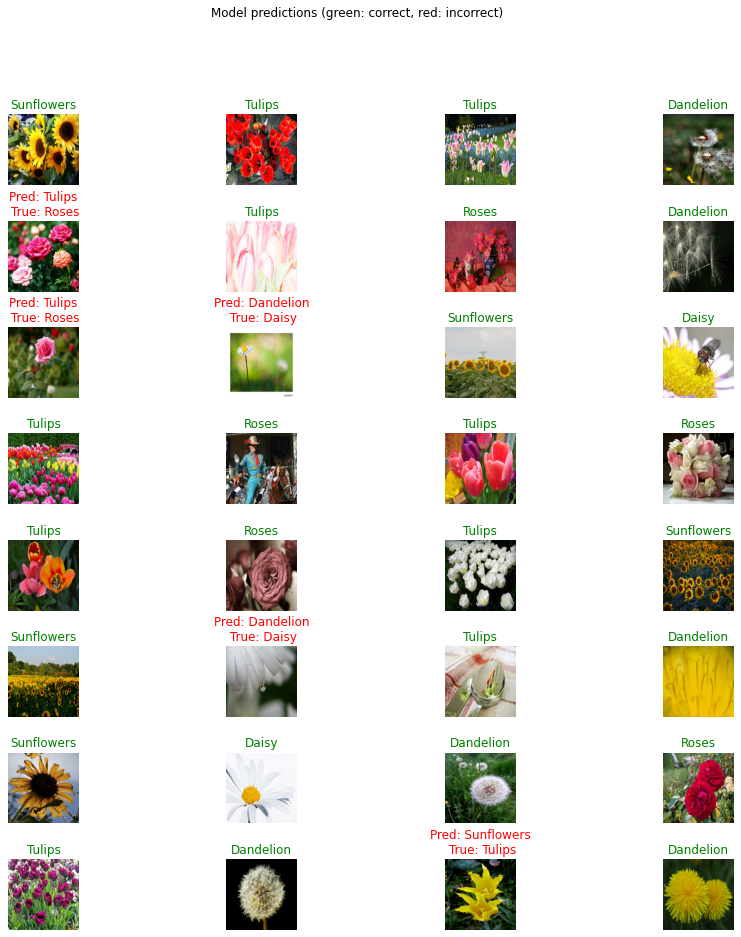

In [73]:
plt.figure(figsize=(15,15))
plt.subplots_adjust(hspace=0.5)
for n in range(32):
  plt.subplot(8,4,n+1)
  plt.imshow(image_batch[n])

    
  if predicted_id[n] == label_id[n]: 
    color = "green"
    plt.title(predicted_label_batch[n].title(), color=color)
  else: 
    color= "red"
    plt.title("Pred: {}\n True: {}".format(predicted_label_batch[n].title(), class_names[label_id[n]]), 
              color=color)

  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

# Export your model

In [74]:
#Now that you've trained the model, export it as a saved model:

import time
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path, save_format='tf')

export_path


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: /tmp/saved_models/1597684156/assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1597684156/assets


'/tmp/saved_models/1597684156'

In [75]:
# Now confirm that we can reload it, and it still gives the same results:

reloaded = tf.keras.models.load_model(export_path)

result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

abs(reloaded_result_batch - result_batch).max()

0.0

**all are good**